In [677]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import scipy.stats as st
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 1000)

In [678]:
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, legend=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                plt.scatter(X_projected[:, d1], X_projected[:, d2], c = illustrative_var, alpha=alpha, cmap="viridis")
                if legend is not None :
                    plt.colorbar(label = legend)

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()
    
    
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

Début du nettoyage du Dataframe building 2015

Je charge le dataset de 2015
#Desktop/Formation_Ingenieur_Machine_Learning/P3_voelker_jean-florent

In [679]:
def CustomParser(data):
    #data = data.replace("'{"", "\"")
    data = data.replace("\'", "\"")
    data = data.replace("\"{\"", "[{\"")
    data = data.replace("\"}\"", "\"}]")
    data = data.replace("True", "\"True\"")
    data = data.replace("False", "\"False\"")
    j1 = json.loads(data)
    return j1

In [680]:
cd Desktop/Formation_Ingenieur_Machine_Learning/P3_voelker_jean-florent

[Errno 2] No such file or directory: 'Desktop/Formation_Ingenieur_Machine_Learning/P3_voelker_jean-florent'
/Users/jfv/Desktop/Formation_Ingenieur_Machine_Learning/P3_voelker_jean-florent


In [681]:
df_building_15 = pd.read_csv('2015-building-energy-benchmarking.csv', converters={'Location':CustomParser}, delimiter=',')

Je charge le dataset de 2016

In [682]:
df_building_16 = pd.read_csv('2016-building-energy-benchmarking.csv', delimiter=',')

Je fusionne les 2 datasets

In [683]:
liste_colonnes_diff_1 = set(df_building_15.columns.values) - set(df_building_16.columns.values)
liste_colonnes_diff_1

{'Comment',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)'}

In [684]:
df_building_15[liste_colonnes_diff_1]

,GHGEmissionsIntensity(kgCO2e/ft2),Location,GHGEmissions(MetricTonsCO2e),OtherFuelUse(kBtu),Comment
0,2.64,{'human_address': [{'address': '405 OLIVE WAY'...,249.43,0.0,NaN
1,2.38,"{'human_address': [{'address': '724 PINE ST', ...",263.51,0.0,NaN
2,1.92,"{'human_address': [{'address': '1900 5TH AVE',...",2061.48,0.0,NaN
3,31.38,{'human_address': [{'address': '620 STEWART ST...,1936.34,0.0,NaN
4,4.02,{'human_address': [{'address': '401 LENORA ST'...,507.70,0.0,NaN
...,...,...,...,...,...
3335,0.07,{'human_address': [{'address': '321 10TH AVE S...,7.97,0.0,NaN
3336,0.61,{'human_address': [{'address': '4123 12TH AVE ...,30.69,0.0,NaN
3337,1.89,"{'human_address': [{'address': '2030 8TH AVE',...",627.97,0.0,NaN
3338,0.04,{'human_address': [{'address': '3801 NE 77TH S...,5.42,0.0,NaN


In [685]:
liste_colonnes_diff_2 = set(df_building_16.columns.values) - set(df_building_15.columns.values)
liste_colonnes_diff_2

{'Address',
 'City',
 'Comments',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

In [686]:
df_building_16[liste_colonnes_diff_2]

,State,Longitude,Address,GHGEmissionsIntensity,ZipCode,City,Latitude,Comments,TotalGHGEmissions
0,WA,-122.33799,405 Olive way,2.83,98101.0,Seattle,47.61220,NaN,249.98
1,WA,-122.33393,724 Pine street,2.86,98101.0,Seattle,47.61317,NaN,295.86
2,WA,-122.33810,1900 5th Avenue,2.19,98101.0,Seattle,47.61393,NaN,2089.28
3,WA,-122.33664,620 STEWART ST,4.67,98101.0,Seattle,47.61412,NaN,286.43
4,WA,-122.34047,401 LENORA ST,2.88,98121.0,Seattle,47.61375,NaN,505.01
...,...,...,...,...,...,...,...,...,...
3371,WA,-122.31154,1600 S Dakota St,1.70,NaN,Seattle,47.56722,NaN,20.94
3372,WA,-122.32283,719 8th Ave S,2.01,NaN,Seattle,47.59625,NaN,32.17
3373,WA,-122.35784,1920 1st Ave W,16.99,NaN,Seattle,47.63644,NaN,223.54
3374,WA,-122.32431,8319 8th Ave S,1.57,NaN,Seattle,47.52832,NaN,22.11


Le dataset de 2015 contient les colonnes suivantes qui ne sont pas comprisent dans le dataset de 2016:
#Comment
#GHGEmissions(MetricTonsCO2e)
#GHGEmissionsIntensity(kgCO2e/ft2)
#Location
#OtherFuelUse(kBtu)

Le dataset de 2016 contient les colonnes suivantes qui ne sont pas comprisent dans le dataset de 2015:
#Address
#City
#Comments
#GHGEmissionsIntensity
#Latitude
#Longitude
#State
#TotalGHGEmissions
#ZipCode

In [687]:
df_building_15_V2 = df_building_15.copy()
df_building_16_V2 = df_building_16.copy()

Je renomme les variables suivantes du dataset de 2016 :
#GHGEmissionsIntensity -> GHGEmissionsIntensity(kgCO2e/ft2)
#TotalGHGEmissions -> GHGEmissions(MetricTonsCO2e)

In [688]:
df_building_16_V2 = df_building_16_V2.rename(columns={"GHGEmissionsIntensity": "GHGEmissionsIntensity(kgCO2e/ft2)", "TotalGHGEmissions": "GHGEmissions(MetricTonsCO2e)"}).copy()

La variable 'OtherFuelUse(kBtu)' n'est pas présente dans le dataset de 2016. Est-il possible de la supprimer sans biaiser le dataset 2015? 

In [689]:
df_building_15_V2['OtherFuelUse(kBtu)'].sum()*100/df_building_15_V2['NaturalGas(kBtu)'].sum()

0.5698777079913118

In [690]:
df_building_15_V2['OtherFuelUse(kBtu)'].sum()*100/df_building_15_V2['Electricity(kBtu)'].sum()

0.2056398108362263

In [691]:
df_building_15_V2['OtherFuelUse(kBtu)'].sum()*100/df_building_15_V2['SteamUse(kBtu)'].sum()

2.8536664335059143

Cette énergie représente entre 0,2% et 2,5% de l'usage des autres énergie. Cette énergie est faiblement utilisée et en perte de vitesse via les politiques publiques qui incitent à son abandon en faveur du gaz ou d'autres énergies. 
Il se trouve que les chaudières fuel peuvent se convertir en chaudière gaz par simple remplacement du brûleur (il existe même des chaudières fuel/gaz), l'abandon du fuel se fait donc souvent en milieu urbain en faveur du gaz, je vais donc rajouter les valeurs du fuel au valeurs du gaz et supprimer la variable dédiée. Ce n'est pas idéal mais simplement supprimer la variable reviendrait à faire disparaître une partie de la consommation des bâtiments concernés et ce serait un biais plus important.

In [692]:
df_building_15_V2['NaturalGas(kBtu)'].sum(), df_building_15_V2['OtherFuelUse(kBtu)'].sum()

(4173502958.0, 23783863.0)

Je ne retire aucune information particulière pour la consommation et les émission avec les variables 'Comment' et 'Location', je les supprime

Je supprime les variables suivantes du dataset de 2015 :
#OtherFuelUse(kBtu)
#Comment
#Location

In [693]:
df_building_15_V2 = df_building_15_V2.drop(['OtherFuelUse(kBtu)','Comment','Location'], axis=1).copy()

Je supprime les variables suivantes du dataset de 2016, car elles ne m'apportent aucune information concernant les émissions ou les consommation d'énergie :
#Address
#State
#City
#Latitude
#Longitude
#ZipCode
#Comments

In [694]:
df_building_16_V2 = df_building_16_V2.drop(columns=['Address','State','City','Latitude','Longitude','ZipCode','Comments'], axis=1).copy()

Je vérifie que mes 2 datasets contiennent désormais les même colonnes

In [695]:
set(df_building_15_V2.columns.values) - set(df_building_16_V2.columns.values)

set()

In [696]:
set(df_building_16_V2.columns.values) - set(df_building_15_V2.columns.values)

set()

Je vérifie que ces colonnes ont le même type

In [697]:
df_building_15_V2.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Outlier
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,249.43,2.64,No,Compliant,NaN
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,263.51,2.38,No,Compliant,NaN
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,2061.48,1.92,Yes,Compliant,NaN
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,1936.34,31.38,No,Compliant,High Outlier
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,507.70,4.02,No,Compliant,NaN


In [698]:
df_building_16_V2.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2)
0,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,0659000475,7,DOWNTOWN,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,0659000640,7,DOWNTOWN,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),0659000970,7,DOWNTOWN,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,NaN,505.01,2.88


J'ai une différence de type pour la variable 'DefaultData'. Je convertis la colonne 'DefaultData' du dataset de 2015 en boolean

In [699]:
df_building_15_V2['DefaultData'] = df_building_15_V2['DefaultData'].apply(lambda x: True if x == 'Yes' else False)

Je fusionne les 2 datasets.

In [700]:
df_building_15_16_V2 = df_building_15_V2.append(df_building_16_V2, sort=False)

Je réalise une première étude du taux de remplissage du dataframe

In [701]:
nb_lignes = df_building_15_16_V2.index.size

rows = []

for nom_colonne in df_building_15_16_V2.columns.values :
    nb_na = df_building_15_16_V2[nom_colonne].isna().sum()
    rate_na = 100 * (1 - nb_na/nb_lignes)
    rows.append([nom_colonne,nb_na,rate_na])
    
df_remplissage_colonnes = pd.DataFrame(rows, columns=["Nom","nb na","% remplissage"]).sort_values(by=["% remplissage"],ascending=False)
df_remplissage_colonnes 

,Nom,nb na,% remplissage
0,OSEBuildingID,0,100.000000
8,YearBuilt,0,100.000000
36,DefaultData,0,100.000000
37,ComplianceStatus,0,100.000000
1,DataYear,0,100.000000
12,PropertyGFAParking,0,100.000000
11,PropertyGFATotal,0,100.000000
13,PropertyGFABuilding(s),0,100.000000
7,Neighborhood,0,100.000000
6,CouncilDistrictCode,0,100.000000


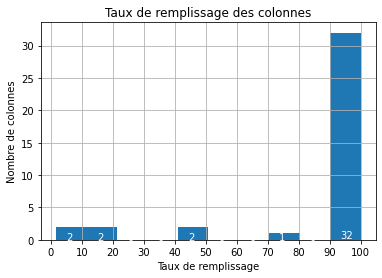

In [702]:
arr = plt.hist(df_remplissage_colonnes["% remplissage"])

for i in range(arr[1].size -1):
    width = arr[1][i+1] - arr[1][i]
    high = arr[0][i]
    plt.text(arr[1][i]+ width/3,arr[0][i]- high/1.01,str("{:.0f}".format(arr[0][i])), color = "white")
    
plt.title("Taux de remplissage des colonnes", fontsize=12)
plt.xlabel("Taux de remplissage", fontsize=10)
plt.ylabel("Nombre de colonnes", fontsize=10)
plt.grid()
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.show()

J'ai plutôt un bon taux de remplissage de mes variables

Les 7 variables en dessous de 97% sont:
    #-ENERGYSTARScore => c'est normal tous les bâtiments ne sont pas encore certifiés
    #-SecondLargestPropertyUseTypeGFA => OK, tous les bâtiments n'ont pas de 2 types d'utilisation
    #-SecondLargestPropertyUseType => OK, tous les bâtiments n'ont pas de 2 types d'utilisation
    #-ThirdLargestPropertyUseType => OK, tous les bâtiments n'ont pas de 3 types d'utilisation
    #-ThirdLargestPropertyUseTypeGFA => OK, tous les bâtiments n'ont pas de 3 types d'utilisation
    #-YearsENERGYSTARCertified => information inutile, je la supprime
    #-Outlier => c'est un tag qui indique si le bâtiment a des valeurs sortant de la norme

La variable "Outlier" identifie déjà des bâtiments avec des valeurs anormales. Je vais l'exploiter en supprimant les individus ayant une valeur différente de "NaN" et je supprime cette variables ensuite.

In [703]:
df_building_15_16_V3 = df_building_15_16_V2[df_building_15_16_V2['Outlier'].isnull()].copy()

In [704]:
df_building_15_16_V3 = df_building_15_16_V3.drop('Outlier', axis =1).copy()

Je regarde l'intérêt de la colonne 'ComplianceStatus'

In [705]:
df_building_15_16_V3['ComplianceStatus'].unique()

array(['Compliant', 'Not Compliant', 'Error - Correct Default Data',
       'Missing Data', 'Non-Compliant'], dtype=object)

In [706]:
df_building_15_16_V3[df_building_15_16_V3['ComplianceStatus']!='Compliant']

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus
767,19798,2015,Multifamily LR (1-4),Low-Rise Multifamily,SANDHURST APTS,225049032,4,NORTHEAST,1977,1.0,3.0,33166,0,33166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Not Compliant
1346,21548,2015,Multifamily LR (1-4),Low-Rise Multifamily,PUGET VISTA APTS,1992200030,7,MAGNOLIA / QUEEN ANNE,1967,1.0,4.0,40086,6133,33953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Not Compliant
1838,23508,2015,Multifamily LR (1-4),Low-Rise Multifamily,SEAVIEW CONDOMINIUM,7677290000,7,MAGNOLIA / QUEEN ANNE,1930,1.0,3.0,53040,0,53040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Not Compliant
22,28,2016,SPS-District K-12,K-12 School,Graham Hill Elementary,1102000138,2,SOUTHEAST,1961,1.0,2.0,56228,0,56228,K-12 School,K-12 School,58916.0,NaN,NaN,NaN,NaN,NaN,95.0,26.100000,29.100000,60.700001,64.599998,1.539478e+06,1.713624e+06,0.0000,2.746059e+05,9.369550e+05,6025.229004,6.025230e+05,38.53,0.69,True,Error - Correct Default Data
28,34,2016,SPS-District K-12,K-12 School,Meany Building,0688000090,3,Central,1955,1.0,1.0,126351,0,126351,K-12 School,K-12 School,126351.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.00,0.00,False,Missing Data
30,36,2016,SPS-District K-12,K-12 School,Jane Addams Middle,0752000170,5,NORTH,1949,1.0,2.0,160645,0,160645,K-12 School,K-12 School,164229.0,NaN,NaN,NaN,NaN,NaN,75.0,41.299999,47.500000,68.099998,75.699997,6.779173e+06,7.800350e+06,0.0000,5.708092e+05,1.947601e+06,48315.718750,4.831572e+06,270.18,1.68,True,Error - Correct Default Data
31,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,0809000005,7,MAGNOLIA / QUEEN ANNE,1989,1.0,2.0,51582,0,51582,K-12 School,K-12 School,55166.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0000,4.386917e+05,1.496816e+06,0.000000,0.000000e+00,10.43,0.20,False,Missing Data
38,51,2016,SPS-District K-12,K-12 School,Eckstein Middle,0425049022,4,NORTHEAST,1950,1.0,2.0,175565,0,175565,K-12 School,K-12 School,182861.0,NaN,NaN,NaN,NaN,NaN,88.0,35.000000,40.099998,55.000000,60.400002,6.399128e+06,7.329818e+06,0.0000,4.688405e+05,1.599684e+06,47994.433590,4.799443e+06,266.05,1.52,True,Error - Correct Default Data
62,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,2518400005,1,SOUTHWEST,1948,1.0,2.0,53352,0,53352,K-12 School,K-12 School,65568.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0000,1.760881e+05,6.008130e+05,0.000000,0.000000e+00,4.19,0.08,False,Missing Data
81,118,2016,SPS-District K-12,K-12 School,Pathfinder K-8,1324039116,1,DELRIDGE,1999,1.0,3.0,74468,0,74468,K-12 School,K-12 School,75364.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0000,4.977068e+05,1.698176e+06,0.000000,0.000000e+00,11.84,0.16,False,Missing Data


La variable "ComplianceStatus" identifie des bâtiments qui n'ont pas transmis les données nécessaire. Je supprime les individus n'ayant pas la valeur "Compliant" et je retire cette varibale ensuite. 

In [707]:
df_building_15_16_V4 = df_building_15_16_V3[df_building_15_16_V3['ComplianceStatus'] == 'Compliant'].copy()

In [708]:
df_building_15_16_V4 = df_building_15_16_V4.drop('ComplianceStatus', axis =1).copy()

DefaultData signifie que l'enregistrement est rempli avec des données par défaut. Cela introduit un biais de les conserver. Je vais supprimer les lignes avec True et je supprime la variable en suite

In [709]:
df_building_15_16_V5 = df_building_15_16_V4[df_building_15_16_V4['DefaultData'] == False].copy()

In [710]:
df_building_15_16_V5 = df_building_15_16_V5.drop('DefaultData', axis =1).copy()

Compte tenu du faible taux de remplissage de 'YearsENERGYSTARCertified' et du faible intérêt pour la prédiction des émissions et conssommations, je la retire.

In [711]:
df_building_15_16_V5 = df_building_15_16_V5.drop('YearsENERGYSTARCertified', axis =1).copy()

La variable 'ListOfAllPropertyUseTypes' est la concaténation des colonnes 'LargestPropertyUseType', 'SecondLargestPropertyUseType' et 'ThirdLargestPropertyUseType'. C'est donc une variable redondante. Je la retire.

In [712]:
df_building_15_16_V5 = df_building_15_16_V5.drop('ListOfAllPropertyUseTypes', axis =1).copy()

Douglas, le project lead, a dit attention à la fuite de données, je propose donc de les anonymiser en supprimant les 3-2 variables suivantes:
 #PropertyName
 #TaxParcelIdentificationNumber

In [713]:
df_building_15_16_V6 = df_building_15_16_V5.drop(['PropertyName','TaxParcelIdentificationNumber'], axis=1).copy()

Certaines variables sont exprimées dans plusieurs unités d'énergie.
#-NaturalGas(therms) => Je retire cette colonne pour ne conserver que NaturalGas(kBtu)
#-Electricity(kWh) => Je retire cette colonne pour ne conserver que Electricity(kBtu)

In [714]:
df_building_15_16_V7 = df_building_15_16_V6.drop(['NaturalGas(therms)','Electricity(kWh)'], axis=1).copy()

Je retire les variables de consommation d'énergie par surface car l'objectif est de prédire la consommation totale d'énergie des sites.

In [715]:
df_building_15_16_V8 = df_building_15_16_V7.drop(['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)'], axis =1).copy()

Je supprime les 2 variables se rapportant à la localisation du bien: 'CouncilDistrictCode','Neighborhood' acr elles ne me renseignent pas sur la performance énergétique du bien.

In [716]:
df_building_15_16_V10 = df_building_15_16_V8.drop(['CouncilDistrictCode','Neighborhood'], axis=1).copy()

Concernant les émissions de CO2, j'ai 2 variables redondantes 'GHGEmissions(MetricTonsCO2e)' et 'GHGEmissionsIntensity(kgCO2e/ft2)'.



In [717]:
df_building_15_16_V10["GHGEmissions(MetricTonsCO2e)"].dropna().shape[0]

5928

In [718]:
df_building_15_16_V10["GHGEmissionsIntensity(kgCO2e/ft2)"].dropna().shape[0]

5928

Les deux variables sont aussi bien renseignées.

In [719]:
df_building_15_16_V10[["GHGEmissions(MetricTonsCO2e)","GHGEmissionsIntensity(kgCO2e/ft2)"]][df_building_15_16_V10["GHGEmissionsIntensity(kgCO2e/ft2)"].isnull()].drop_duplicates()

,GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2)
1358,NaN,NaN


Les deux variables sont renseignées identiquement, je ne peux utiliser l'une pout complément l'autre par conversion de données.

In [720]:
st.pearsonr(df_building_15_16_V10["GHGEmissions(MetricTonsCO2e)"].dropna(),df_building_15_16_V10["GHGEmissionsIntensity(kgCO2e/ft2)"].dropna())[0]

0.4454066938776018

Elles ne sont pas corrélées. Mais elles sont liées, car 'GHGEmissionsIntensity(kgCO2e/ft2)' est calculée en divisant 'GHGEmissions(MetricTonsCO2e)' par la surface du bâtiment. Comme je conserve la surperfie du bâtiment , je vais conserver qu'un seule variable.

L'énoncé du projet parle de prédire la consommation totale d’énergie du bâtiment, je conserve donc 'GHGEmissions(MetricTonsCO2e)' et retire 'GHGEmissionsIntensity(kgCO2e/ft2)'.

In [721]:
df_building_15_16_V11 = df_building_15_16_V10.drop(['GHGEmissionsIntensity(kgCO2e/ft2)'], axis=1).copy()

D'après la description des colonnes, la variable 'PropertyGFATotal' est la somme de 'PropertyGFAParking' et 'PropertyGFABuilding'.

In [722]:
df_building_15_16_V11['PropertyGFATotal'][
    (  df_building_15_16_V11['PropertyGFABuilding(s)']
     + df_building_15_16_V11['PropertyGFAParking']
     - df_building_15_16_V11['PropertyGFATotal']
    )!=0]

Series([], Name: PropertyGFATotal, dtype: int64)

La vérification ci-dessus, montre qu'il n'y a aucune ligne où cette règle n'est pas respectée.
#Je retire la variable 'PropertyGFATotal'.

In [723]:
df_building_15_16_V12 = df_building_15_16_V11.drop(['PropertyGFATotal'], axis=1).copy()

D'après la documentation DataYear est l'année de construction ou l'année de rénovation le cas échéant.

In [724]:
df_building_15_16_V12.groupby('DataYear').count()

,OSEBuildingID,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)
DataYear,,,,,,,,,,,,,,,,,,,,,
2015,2723,2723,2723,2723,2723,2718,2723,2723,2596,2596,1376,1376,499,499,1964,2721,2721,2721,2721,2721,2721
2016,3211,3211,3211,3211,3208,3211,3211,3211,3196,3196,1647,1647,583,583,2399,3211,3210,3207,3207,3207,3207


Un bâtiment est identifié par l'OSEBuildingID. Je remarque qu'il y a des doublons car un même bâtiment peut faire l'objet de déclaration sur plusieurs années successives. Je vais donc faire un filtre en ne gardant que la déclaration la plus récente.

In [725]:
df_building_15_16_V16 = df_building_15_16_V12.drop_duplicates(subset='OSEBuildingID',keep='last').copy()
df_building_15_16_V16.groupby('DataYear').count()

,OSEBuildingID,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)
DataYear,,,,,,,,,,,,,,,,,,,,,
2015,71,71,71,71,71,70,71,71,47,47,25,25,8,8,48,70,70,70,70,70,70
2016,3211,3211,3211,3211,3208,3211,3211,3211,3196,3196,1647,1647,583,583,2399,3211,3210,3207,3207,3207,3207


Je n'ai perdu aucun individu de 2016, par contre les individus de 2015 sont passés de 2723 à 71. 
#Nous avons bien retiré les doublons pour conserver les enregistrements les plus récents.

Je vérifie que "LargestPropertyUseType" et "PrimaryPropertyType" sont bien corrélées.

In [726]:
X = "LargestPropertyUseType"
Y = "PrimaryPropertyType"
cont = df_building_15_16_V16[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).copy().astype(int)
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)

In [727]:
st_p

0.0

La valeur de p est inférieure à 0,05. L'hypothèse nulle (H0) peut donc être rejetée. L'association entre les variables est statistiquement significative.

In [728]:
df_building_15_16_V16[["BuildingType","PrimaryPropertyType","LargestPropertyUseType"]].describe()

,BuildingType,PrimaryPropertyType,LargestPropertyUseType
count,3282,3282,3243
unique,8,26,57
top,NonResidential,Low-Rise Multifamily,Multifamily Housing
freq,1467,973,1639


Je retire PrimaryPropertyType car redondant avec LargestPropertyUseType et BuildingType
#Je retire aussi OSEBuildingID et DataYear qui sont devenues inutiles après la suppression des doublons.

In [729]:
df_building_15_16_V17 = df_building_15_16_V16.drop(['OSEBuildingID','DataYear','PrimaryPropertyType'], axis=1).copy()

J'analyse les variables restantes (outliers, corrélation):

D'après l'énoncé du projet, nous nous intéressons aux émissions des bâtiments non destinés à l'habitation. 

In [730]:
df_building_15_16_V17['BuildingType'].unique()

array(['SPS-District K-12', 'Multifamily LR (1-4)', 'NonResidential',
       'Multifamily HR (10+)', 'Multifamily MR (5-9)',
       'Nonresidential COS', 'Campus', 'Nonresidential WA'], dtype=object)

Je retire les types 'Multifamily LR (1-4)', 'Multifamily MR (5-9)' et 'Multifamily HR (10+)'

In [731]:
df_building_15_16_V17 = df_building_15_16_V17[
    (df_building_15_16_V17['BuildingType'] != 'Multifamily LR (1-4)') &
    (df_building_15_16_V17['BuildingType'] != 'Multifamily MR (5-9)') &
    (df_building_15_16_V17['BuildingType'] != 'Multifamily HR (10+)')].copy()

In [732]:
df_building_15_16_V17['BuildingType'].unique()

array(['SPS-District K-12', 'NonResidential', 'Nonresidential COS',
       'Campus', 'Nonresidential WA'], dtype=object)

Je vais maintenant regarder si 'BuildingType' est redondant avec 'LargestPropertyUseType'

In [733]:
X = "BuildingType"
Y = "LargestPropertyUseType"
cont = df_building_15_16_V17[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).copy().astype(int)
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)

In [734]:
st_p

1.767522083114202e-96

La valeur de p est inférieure à 0,05. L'hypothèse nulle (H0) peut donc être rejetée. L'association entre les variables est statistiquement significative.
#Je retire donc 'BuildingType'

In [735]:
df_building_15_16_V17 = df_building_15_16_V17.drop(['BuildingType'], axis=1).copy()

Je vérifie s'il y a des outliers pour la variable 'YearBuilt'

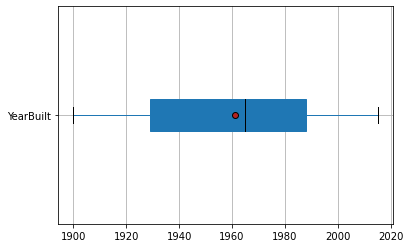

In [736]:
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
df_building_15_16_V17.boxplot(column = "YearBuilt", showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Je n'identifie pas d'outliers pour la variable 'YearBuilt'

Je vérifie s'il y a des outliers pour la variable 'NumberofBuildings'

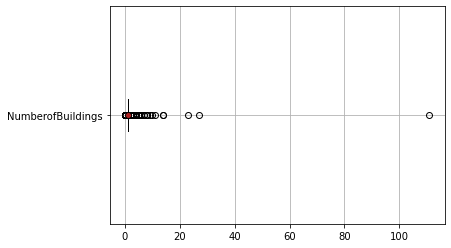

In [737]:
df_building_15_16_V17.boxplot(column = "NumberofBuildings", showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

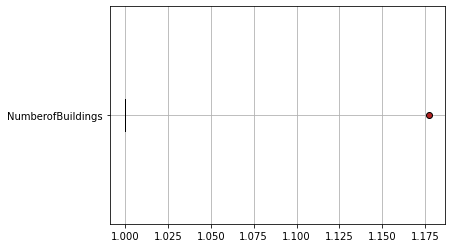

In [738]:
df_building_15_16_V17.boxplot(column = "NumberofBuildings", showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [739]:
df_building_15_16_V17[df_building_15_16_V17["NumberofBuildings"]<1].shape[0]

52

In [740]:
df_building_15_16_V17[df_building_15_16_V17["NumberofBuildings"]>1].shape[0]

53

Les valeurs quantiles1-1.5IQ et quantiles3+1.5IQ sont confondues en 1. Je supprime les bâtiments (lot foncier) dont le nombre de bâtiment est différent de 1.

In [741]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["NumberofBuildings"]==1].copy()

In [742]:
df_building_15_16_V17.shape[0]

1490

Je supprime la variable "NumberofBuildings", puisque désormais toutes parcelles n'ont qu'un building

In [743]:
df_building_15_16_V17 = df_building_15_16_V17.drop(['NumberofBuildings'], axis=1).copy()

Je vérifie s'il y a des outliers pour la variable 'NumberofFloors'

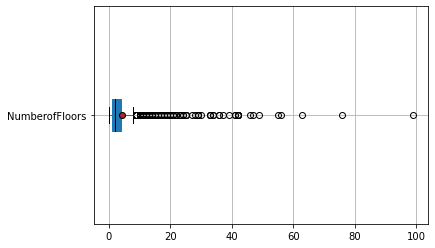

In [744]:
df_building_15_16_V17.boxplot(column = "NumberofFloors", showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

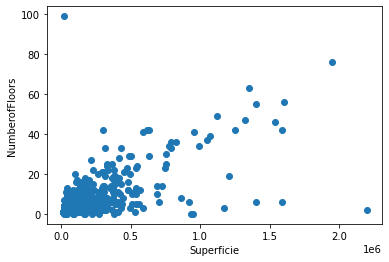

In [745]:
plt.plot(df_building_15_16_V17["PropertyGFAParking"]+df_building_15_16_V17["PropertyGFABuilding(s)"],df_building_15_16_V17["NumberofFloors"], "o")
plt.xlabel("Superficie")
plt.ylabel("NumberofFloors")
plt.show()

In [746]:
df_building_15_16_V17[df_building_15_16_V17["NumberofFloors"]>40].shape[0]

15

Je ne conserve que les bâtiments avec moins de 9 étages

In [747]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["NumberofFloors"]<=40].copy()

Je vérifie s'il y a des outliers pour la variable 'LargestPropertyUseTypeGFA'

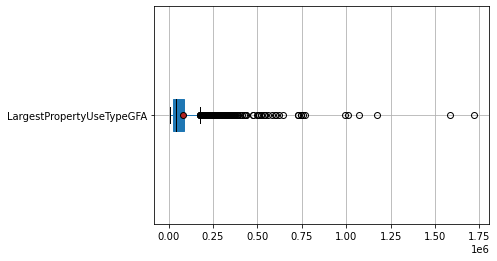

In [748]:
df_building_15_16_V17.boxplot(column = "LargestPropertyUseTypeGFA", showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [749]:
df_building_15_16_V17[df_building_15_16_V17["LargestPropertyUseTypeGFA"]>1000000].shape[0]

5

In [750]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["LargestPropertyUseTypeGFA"]<=1000000].copy()

In [751]:
df_building_15_16_V17.shape[0]

1453

Je regarde si les 'SecondLargestPropertyUseTypeGFA' sont bien inférieure à 'LargestPropertyUseTypeGFA'

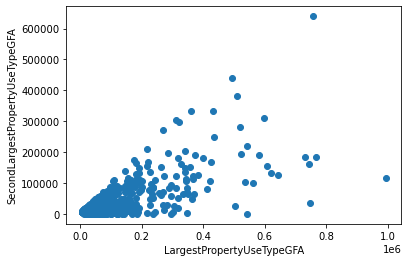

In [752]:
plt.plot(df_building_15_16_V17["LargestPropertyUseTypeGFA"],df_building_15_16_V17["SecondLargestPropertyUseTypeGFA"], "o")
plt.xlabel("LargestPropertyUseTypeGFA")
plt.ylabel("SecondLargestPropertyUseTypeGFA")
plt.show()

Les 'SecondLargestPropertyUseTypeGFA' sont bien en-dessous d'une droite égale à 'LargestPropertyUseTypeGFA'. Il n'y a pas de correction à mener.

Je remarque néanmoins un outlier pour SecondLargestPropertyUseTypeGFA > 500 000 sf

In [753]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["SecondLargestPropertyUseTypeGFA"].fillna(0)<=500000].copy()

Je regarde si les 'ThirdLargestPropertyUseTypeGFA' sont bien inférieure à 'SecondLargestPropertyUseTypeGFA'

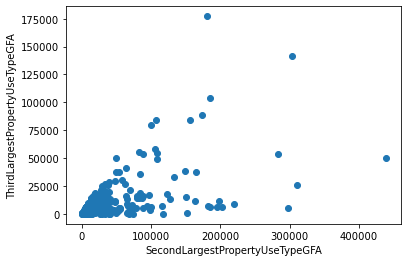

In [754]:
plt.plot(df_building_15_16_V17["SecondLargestPropertyUseTypeGFA"],df_building_15_16_V17["ThirdLargestPropertyUseTypeGFA"], "o")
plt.xlabel("SecondLargestPropertyUseTypeGFA")
plt.ylabel("ThirdLargestPropertyUseTypeGFA")
plt.show()

J'identifie un lot de 3 bâtiments qui se détachent vraiment en haut à droite du graphique, je les retire

In [755]:
df_building_15_16_V17[df_building_15_16_V17["ThirdLargestPropertyUseTypeGFA"].fillna(0)>100000]

,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)
230,2002,37.0,164420,888049,Office,765351.0,Parking,185581.0,Financial Office,103478.0,93.0,41213584.0,42071712.0,0.0,41213579.0,0.0,287.32
2313,2009,39.0,112124,962428,Multifamily Housing,311521.0,Hotel,303000.0,Parking,141450.0,65.0,26416770.0,26932200.0,0.0,20663978.0,5752789.0,449.59
2530,2009,19.0,201857,1004813,Office,319361.0,Multifamily Housing,181047.0,Parking,177210.0,87.0,27684480.0,27917688.0,0.0,23343425.0,4341053.0,393.29


In [756]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["ThirdLargestPropertyUseTypeGFA"].fillna(0)<=100000].copy()

In [757]:
df_building_15_16_V17.shape[0]

1449

Je standardise les orthographes des catégories pour les 3 types d'utlisations

In [758]:
df_building_15_16_V17['LargestPropertyUseType']= df_building_15_16_V17['LargestPropertyUseType'].apply(lambda x: str(x).upper().replace(" ",""))
df_building_15_16_V17['SecondLargestPropertyUseType']= df_building_15_16_V17['SecondLargestPropertyUseType'].apply(lambda x: str(x).upper().replace(" ",""))
df_building_15_16_V17['ThirdLargestPropertyUseType']= df_building_15_16_V17['ThirdLargestPropertyUseType'].apply(lambda x: str(x).upper().replace(" ",""))

Je vérifie s'il y a des outliers pour la variable 'ENERGYSTARScore'

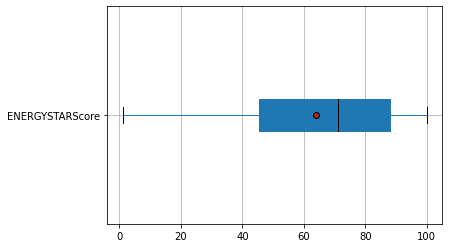

In [759]:
df_building_15_16_V17.boxplot(column = "ENERGYSTARScore", showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Celui-ci est bien compris entre 0 et 100. Il n'y a pas de valeur aberrante.

Je vérifie s'il y a des outliers pour la variable 'SourceEUIWN(kBtu/sf)'

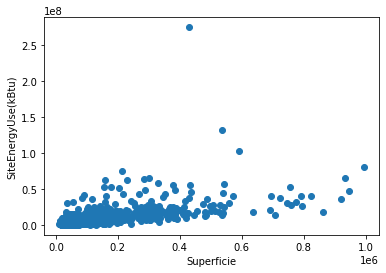

In [760]:
plt.plot(df_building_15_16_V17["PropertyGFAParking"]+df_building_15_16_V17["PropertyGFABuilding(s)"],df_building_15_16_V17["SiteEnergyUse(kBtu)"], "o")
plt.xlabel("Superficie")
plt.ylabel("SiteEnergyUse(kBtu)")
plt.show()

In [761]:
df_building_15_16_V17[df_building_15_16_V17["SiteEnergyUse(kBtu)"].fillna(0)>0.5*10**8]

,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)
498,2008,15.0,250000,184475,MEDICALOFFICE,434475.0,PARKING,250000.0,NAN,NaN,60.0,55030192.0,56652364.0,21474092.0,33557492.0,0.0,1891.47
49,1982,34.0,146694,847518,HOTEL,994212.0,PARKING,117668.0,SWIMMINGPOOL,0.0,63.0,80469216.0,82318072.0,11598686.0,45545529.0,23324992.0,2451.58
165,1999,0.0,0,934292,HOTEL,495536.0,PARKING,438756.0,RESTAURANT,49700.0,NaN,65047284.0,66502836.0,0.0,39364114.0,25683162.0,1638.46
186,1955,15.0,0,230880,OTHER,203000.0,NAN,NaN,NAN,NaN,NaN,62197176.0,61674856.0,0.0,62197171.0,0.0,433.60
215,2004,11.0,68432,230638,OTHER,250000.0,NAN,NaN,NAN,NaN,NaN,65336980.0,66000296.0,0.0,30651644.0,34685331.0,2055.82
262,1923,12.0,0,542305,HOTEL,542305.0,SWIMMINGPOOL,0.0,NAN,NaN,45.0,56485204.0,57051236.0,28438884.0,24078107.0,3968211.0,2573.75
285,1985,30.0,134662,620338,OFFICE,643083.0,PARKING,126891.0,RESTAURANT,13422.0,72.0,52226204.0,53974556.0,519390.0,43199963.0,8506844.0,793.05
308,2001,6.0,177660,200783,PARKING,164332.0,OFFICE,108781.0,DATACENTER,54184.0,100.0,55073120.0,55073120.0,0.0,53506520.0,1566594.0,456.22
309,2001,6.0,104922,108912,PARKING,104922.0,DATACENTER,54385.0,OFFICE,37721.0,100.0,75073888.0,75073888.0,0.0,74917352.0,156525.0,530.59
329,1975,8.0,0,158738,URGENTCARE/CLINIC/OTHEROUTPATIENT,158738.0,NAN,NaN,NAN,NaN,NaN,61762380.0,61214744.0,5650343.5,46528618.0,9571816.0,1268.87


Je retire ces sites car ils sont atypiques.

In [762]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["SiteEnergyUse(kBtu)"].fillna(0)<=0.5*10**8].copy()

Je regarde s'il y a des valeurs négatives ou nulles ce qui serait aberrant.

In [763]:
df_building_15_16_V17[df_building_15_16_V17["SiteEnergyUse(kBtu)"]<=0]

,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)


je retire ces bâtiments.

In [764]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["SiteEnergyUse(kBtu)"].fillna(0)>0].copy()

Je vérifie s'il y a des outliers pour la variable 'SteamUse(kBtu)'

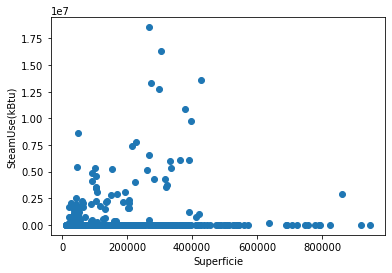

In [765]:
plt.plot(df_building_15_16_V17["PropertyGFAParking"]+df_building_15_16_V17["PropertyGFABuilding(s)"],df_building_15_16_V17["SteamUse(kBtu)"], "o")
plt.xlabel("Superficie")
plt.ylabel("SteamUse(kBtu)")
plt.show()

Je remarque que je n'ai pas beaucoup de bâtiments alimenté par de la vapeur

In [766]:
df_building_15_16_V17[df_building_15_16_V17["SteamUse(kBtu)"]>0].shape[0]*100/df_building_15_16_V17.shape[0]

6.643356643356643

In [767]:
df_building_15_16_V17[df_building_15_16_V17["SteamUse(kBtu)"].fillna(0)>20000000]

,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)


Je retire les sites avec plus de 10000000 kBtu, car ils sont atypiques.

In [768]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["SteamUse(kBtu)"].fillna(0)<=20000000].copy()

Je vérifie s'il y a des outliers pour la variable 'Electricity(kBtu)'

In [769]:
df_building_15_16_V17.shape[0]

1430

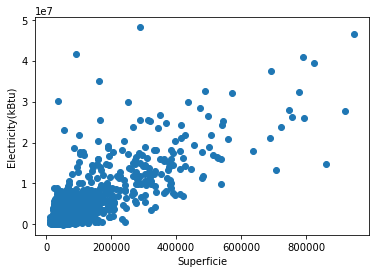

In [770]:
plt.plot(df_building_15_16_V17["PropertyGFAParking"]+df_building_15_16_V17["PropertyGFABuilding(s)"], df_building_15_16_V17["Electricity(kBtu)"],"o")
plt.xlabel("Superficie")
plt.ylabel("Electricity(kBtu)")
plt.show()

In [771]:
df_building_15_16_V17[(df_building_15_16_V17["Electricity(kBtu)"].fillna(0)>45000000) & ((df_building_15_16_V17["PropertyGFAParking"]+df_building_15_16_V17["PropertyGFABuilding(s)"])<700000)]

,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)
328,1929,8.0,0,287819,OFFICE,155985.0,DATACENTER,88350.0,OTHER,15630.0,NaN,48406556.0,48037000.0,0.0,48155040.0,251511.0,349.07


Je retire les sites avec plus de 35 000 000 kBtu, car ils sont atypiques.

In [772]:
df_building_15_16_V17 = df_building_15_16_V17[(df_building_15_16_V17["Electricity(kBtu)"].fillna(0)<=45000000) | ((df_building_15_16_V17["PropertyGFAParking"]+df_building_15_16_V17["PropertyGFABuilding(s)"])>=700000)].copy()

In [773]:
df_building_15_16_V17.shape[0]

1429

Je vérifie s'il y a des outliers pour la variable 'NaturalGas(kBtu)'

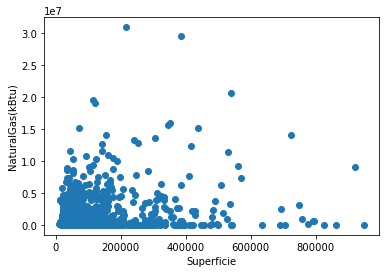

In [774]:
plt.plot(df_building_15_16_V17["PropertyGFAParking"]+df_building_15_16_V17["PropertyGFABuilding(s)"],df_building_15_16_V17["NaturalGas(kBtu)"], "o")
plt.xlabel("Superficie")
plt.ylabel("NaturalGas(kBtu)")
plt.show()

In [775]:
df_building_15_16_V17[df_building_15_16_V17["NaturalGas(kBtu)"].fillna(0)>19000000]


,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)
20,1916,10.0,0,540360,COURTHOUSE,537150.0,NAN,NaN,NAN,NaN,76.0,44984468.0,47023088.0,0.0,24357833.0,20626631.0,1265.29
21,1985,19.0,0,385274,OTHER,385274.0,NAN,NaN,NAN,NaN,NaN,47859812.0,49539212.0,0.0,18257661.0,29602150.0,1699.45
59,1922,5.0,0,217603,SENIORCARECOMMUNITY,296313.0,PARKING,0.0,NAN,NaN,54.0,42792072.0,45547252.0,0.0,11824772.0,30967300.0,1727.11
193,1961,4.0,0,122309,HOTEL,122309.0,NAN,NaN,NAN,NaN,8.0,25453690.0,26122018.0,0.0,6322533.0,19131155.0,1060.13
546,1999,4.0,18382,97366,LABORATORY,97365.0,NAN,NaN,NAN,NaN,NaN,36436388.0,35938164.0,0.0,16913185.0,19523202.0,1154.79


Je retire les sites avec plus de 7500000 kBtu, car ils sont atypiques.

In [776]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["NaturalGas(kBtu)"].fillna(0)<=19000000]

In [777]:
df_building_15_16_V17.shape[0]

1424

Je vérifie s'il y a des outliers pour la variable 'GHGEmissions(MetricTonsCO2e)'

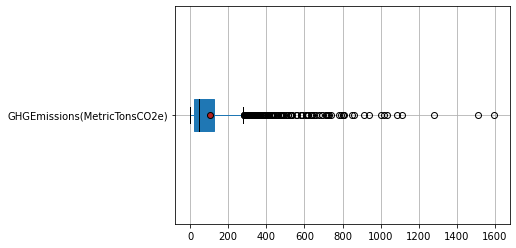

In [778]:
df_building_15_16_V17.boxplot(column = "GHGEmissions(MetricTonsCO2e)", showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

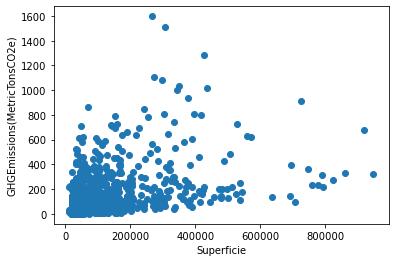

In [779]:
plt.plot(df_building_15_16_V17["PropertyGFAParking"]+df_building_15_16_V17["PropertyGFABuilding(s)"],df_building_15_16_V17["GHGEmissions(MetricTonsCO2e)"], "o")
plt.xlabel("Superficie")
plt.ylabel("GHGEmissions(MetricTonsCO2e)")
plt.show()

Je supprime les bâtiments avec "GHGEmissions(MetricTonsCO2e)" supérieur à 600

In [780]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["GHGEmissions(MetricTonsCO2e)"].fillna(0)<=600]

In [781]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["GHGEmissions(MetricTonsCO2e)"].fillna(0)>0]

In [782]:
df_building_15_16_V17.shape[0]

1386

Je vérifie s'il y a des outliers pour la variable 'PropertyGFAParking'

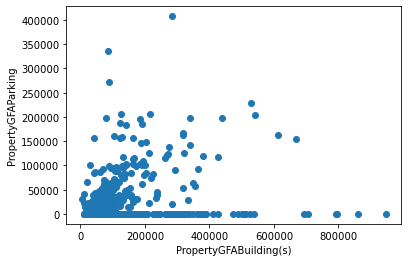

In [783]:
plt.plot(df_building_15_16_V17["PropertyGFABuilding(s)"],df_building_15_16_V17["PropertyGFAParking"], "o")
plt.xlabel("PropertyGFABuilding(s)")
plt.ylabel("PropertyGFAParking")
plt.show()

In [784]:
df_building_15_16_V17[df_building_15_16_V17["PropertyGFAParking"].fillna(0)>250000]

,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e)
162,2008,6.0,335109,84739,PARKING,335109.0,MOVIETHEATER,65000.0,MEDICALOFFICE,13567.0,NaN,9134963.0,9238992.0,0.0,6995246.0,2139716.0,162.41
307,1992,14.0,407795,282363,MEDICALOFFICE,270384.0,PARKING,270383.0,NAN,NaN,58.0,21156670.0,21156670.0,0.0,21156669.0,0.0,147.49
596,2002,6.0,272900,88498,PARKING,232685.0,RETAILSTORE,63419.0,NON-REFRIGERATEDWAREHOUSE,15757.0,NaN,8915523.0,9158207.0,0.0,7663584.0,1251938.0,119.92


Je supprime les bâtiments avec "PropertyGFAParking" supérieur à 250 000

In [785]:
df_building_15_16_V17 = df_building_15_16_V17[df_building_15_16_V17["PropertyGFAParking"].fillna(0)<=250000]

Je vais maintenant pratiquer un One-Hot encodage sur mes variables catégorielles:
#-LargestPropertyUseType
#-SecondLargestPropertyUseType
#-ThirdLargestPropertyUseType

Je commence par regarder le nombre d'occurences pour chaque modalité.

Je réaffecte toutes les modalités avec moins de 10 occurences à la modalité 'OTHER'.

J'applique cette réaffectation à la variable 'LargestPropertyUseType'

In [786]:
Liste_types =  df_building_15_16_V17['LargestPropertyUseType'].value_counts()
Liste_types

OFFICE                                             448
NON-REFRIGERATEDWAREHOUSE                          191
RETAILSTORE                                         89
OTHER                                               78
WORSHIPFACILITY                                     69
HOTEL                                               60
K-12SCHOOL                                          54
DISTRIBUTIONCENTER                                  52
SUPERMARKET/GROCERYSTORE                            39
MEDICALOFFICE                                       34
SELF-STORAGEFACILITY                                25
OTHER-RECREATION                                    23
PARKING                                             21
RESIDENCEHALL/DORMITORY                             20
OTHER-ENTERTAINMENT/PUBLICASSEMBLY                  18
SENIORCARECOMMUNITY                                 15
COLLEGE/UNIVERSITY                                  14
REFRIGERATEDWAREHOUSE                               11
RESTAURANT

Je remarque les catégories 'MULTIFAMILYHOUSING', 'RESIDENCEHALL/DORMITORY' et 'RESIDENTIALCAREFACILITY' qui sont des bâtiments destinés à l’habitation. Je les retire.

In [787]:
df_building_15_16_V17=df_building_15_16_V17[~df_building_15_16_V17['LargestPropertyUseType'].isin(['RESIDENCEHALL/DORMITORY','RESIDENTIALCAREFACILITY','MULTIFAMILYHOUSING'])].copy()

In [788]:
Liste_types_a_reaffecter=[]

for index in Liste_types.index:
    if Liste_types[index] < 10:
        Liste_types_a_reaffecter.append(index)

In [789]:
df_building_15_16_V17['LargestPropertyUseType'] = df_building_15_16_V17['LargestPropertyUseType'].apply(lambda x: 'OTHER' if x in Liste_types_a_reaffecter else x).copy()

J'applique cette réaffectation à la variable 'SecondLargestPropertyUseType'

In [790]:
Liste_types =  df_building_15_16_V17['SecondLargestPropertyUseType'].value_counts()
Liste_types

NAN                                                620
PARKING                                            282
OFFICE                                             151
RETAILSTORE                                         74
OTHER                                               40
NON-REFRIGERATEDWAREHOUSE                           29
RESTAURANT                                          26
FITNESSCENTER/HEALTHCLUB/GYM                        12
OTHER-SERVICES                                      10
DATACENTER                                           9
MEDICALOFFICE                                        8
MULTIFAMILYHOUSING                                   8
BANKBRANCH                                           7
SUPERMARKET/GROCERYSTORE                             6
DISTRIBUTIONCENTER                                   6
OTHER-ENTERTAINMENT/PUBLICASSEMBLY                   6
LABORATORY                                           5
K-12SCHOOL                                           5
REPAIRSERV

Je remarque les catégories 'MULTIFAMILYHOUSING' et 'RESIDENCEHALL/DORMITORY' qui sont des bâtiments destinés à l’habitation. Je les retire.

In [791]:
df_building_15_16_V17=df_building_15_16_V17[~df_building_15_16_V17['SecondLargestPropertyUseType'].isin(['RESIDENCEHALL/DORMITORY','MULTIFAMILYHOUSING'])].copy()

In [792]:
Liste_types_a_reaffecter=[]

for index in Liste_types.index:
    if Liste_types[index] < 10:
        Liste_types_a_reaffecter.append(index)

In [793]:
df_building_15_16_V17['SecondLargestPropertyUseType'] = df_building_15_16_V17['SecondLargestPropertyUseType'].apply(lambda x: 'OTHER' if x in Liste_types_a_reaffecter else x).copy()

J'applique cette réaffectation à la variable 'ThirdLargestPropertyUseType'

In [794]:
Liste_types =  df_building_15_16_V17['ThirdLargestPropertyUseType'].value_counts()
Liste_types

NAN                                                1072
OFFICE                                               42
RETAILSTORE                                          38
PARKING                                              34
OTHER                                                30
RESTAURANT                                           22
NON-REFRIGERATEDWAREHOUSE                            12
MULTIFAMILYHOUSING                                   12
DATACENTER                                           12
SWIMMINGPOOL                                          7
FOODSERVICE                                           7
MEDICALOFFICE                                         6
PRE-SCHOOL/DAYCARE                                    6
SOCIAL/MEETINGHALL                                    5
OTHER-ENTERTAINMENT/PUBLICASSEMBLY                    4
FITNESSCENTER/HEALTHCLUB/GYM                          4
BANKBRANCH                                            4
OTHER-RESTAURANT/BAR                            

Je remarque la catégorie 'MULTIFAMILYHOUSING' qui sont des bâtiments destinés à l’habitation. Je les retire.

In [795]:
df_building_15_16_V17=df_building_15_16_V17[~df_building_15_16_V17['ThirdLargestPropertyUseType'].isin(['MULTIFAMILYHOUSING'])].copy()

In [796]:
Liste_types_a_reaffecter=[]

for index in Liste_types.index:
    if Liste_types[index] < 10:
        Liste_types_a_reaffecter.append(index)

In [797]:
df_building_15_16_V17['ThirdLargestPropertyUseType'] = df_building_15_16_V17['ThirdLargestPropertyUseType'].apply(lambda x: 'OTHER' if x in Liste_types_a_reaffecter else x).copy()

Je constate que je n'ai plus de modalités inférieures à 10.

In [798]:
df_building_15_16_V17['LargestPropertyUseType'].value_counts()

OFFICE                                435
NON-REFRIGERATEDWAREHOUSE             190
OTHER                                 177
RETAILSTORE                            86
WORSHIPFACILITY                        69
HOTEL                                  59
K-12SCHOOL                             54
DISTRIBUTIONCENTER                     52
SUPERMARKET/GROCERYSTORE               39
MEDICALOFFICE                          34
SELF-STORAGEFACILITY                   25
OTHER-RECREATION                       23
PARKING                                20
OTHER-ENTERTAINMENT/PUBLICASSEMBLY     17
SENIORCARECOMMUNITY                    15
COLLEGE/UNIVERSITY                     14
REFRIGERATEDWAREHOUSE                  11
RESTAURANT                             11
Name: LargestPropertyUseType, dtype: int64

In [799]:
df_building_15_16_V17['SecondLargestPropertyUseType'].value_counts()

NAN                             620
PARKING                         275
OFFICE                          150
OTHER                           136
RETAILSTORE                      74
NON-REFRIGERATEDWAREHOUSE        28
RESTAURANT                       26
FITNESSCENTER/HEALTHCLUB/GYM     12
OTHER-SERVICES                   10
Name: SecondLargestPropertyUseType, dtype: int64

In [800]:
df_building_15_16_V17['ThirdLargestPropertyUseType'].value_counts()

NAN                          1072
OTHER                          99
OFFICE                         42
RETAILSTORE                    38
PARKING                        34
RESTAURANT                     22
DATACENTER                     12
NON-REFRIGERATEDWAREHOUSE      12
Name: ThirdLargestPropertyUseType, dtype: int64

Je crée les dummy variables depuis la variable 'LargestPropertyUseType'

In [801]:
LargestPropertyUseType_Dummies = pd.get_dummies(df_building_15_16_V17.LargestPropertyUseType,prefix='Largest').fillna(0)
LargestPropertyUseType_Dummies

,Largest_COLLEGE/UNIVERSITY,Largest_DISTRIBUTIONCENTER,Largest_HOTEL,Largest_K-12SCHOOL,Largest_MEDICALOFFICE,Largest_NON-REFRIGERATEDWAREHOUSE,Largest_OFFICE,Largest_OTHER,Largest_OTHER-ENTERTAINMENT/PUBLICASSEMBLY,Largest_OTHER-RECREATION,Largest_PARKING,Largest_REFRIGERATEDWAREHOUSE,Largest_RESTAURANT,Largest_RETAILSTORE,Largest_SELF-STORAGEFACILITY,Largest_SENIORCARECOMMUNITY,Largest_SUPERMARKET/GROCERYSTORE,Largest_WORSHIPFACILITY
28,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
151,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
272,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
277,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3372,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3373,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3374,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Je crée les dummy variables depuis la variable 'SecondLargestPropertyUseType'

In [802]:
SecondLargestPropertyUseType_Dummies = pd.get_dummies(df_building_15_16_V17.SecondLargestPropertyUseType,prefix='Second').fillna(0)
SecondLargestPropertyUseType_Dummies

,Second_FITNESSCENTER/HEALTHCLUB/GYM,Second_NAN,Second_NON-REFRIGERATEDWAREHOUSE,Second_OFFICE,Second_OTHER,Second_OTHER-SERVICES,Second_PARKING,Second_RESTAURANT,Second_RETAILSTORE
28,0,1,0,0,0,0,0,0,0
81,0,1,0,0,0,0,0,0,0
151,0,1,0,0,0,0,0,0,0
272,0,1,0,0,0,0,0,0,0
277,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
3370,0,1,0,0,0,0,0,0,0
3372,0,1,0,0,0,0,0,0,0
3373,1,0,0,0,0,0,0,0,0
3374,1,0,0,0,0,0,0,0,0


Je crée les dummy variables depuis la variable 'ThirdLargestPropertyUseType'

In [803]:
ThirdLargestPropertyUseType_Dummies = pd.get_dummies(df_building_15_16_V17.ThirdLargestPropertyUseType,prefix='Third').fillna(0)
ThirdLargestPropertyUseType_Dummies

,Third_DATACENTER,Third_NAN,Third_NON-REFRIGERATEDWAREHOUSE,Third_OFFICE,Third_OTHER,Third_PARKING,Third_RESTAURANT,Third_RETAILSTORE
28,0,1,0,0,0,0,0,0
81,0,1,0,0,0,0,0,0
151,0,1,0,0,0,0,0,0
272,0,1,0,0,0,0,0,0
277,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3370,0,1,0,0,0,0,0,0
3372,0,1,0,0,0,0,0,0
3373,0,0,0,0,1,0,0,0
3374,0,0,0,0,1,0,0,0


Lorsqu'on créé des dummies variables, il faut faire attention éviter au "dummy variable trap". Les n dummy variables créées sont corrélées, dans la mesure où si je connais les valeurs de n-1 variables, je connais forcément la valeur de la Nième variables. Il faut donc pour chaque set de dummy variables créé retirer l'une des variables pour supprimer cette corrélation.

In [804]:
LargestPropertyUseType_Dummies = LargestPropertyUseType_Dummies.drop(['Largest_OTHER'], axis=1).copy()

In [805]:
SecondLargestPropertyUseType_Dummies = SecondLargestPropertyUseType_Dummies.drop(['Second_NAN'], axis=1).copy()

In [806]:
ThirdLargestPropertyUseType_Dummies = ThirdLargestPropertyUseType_Dummies.drop(['Third_NAN'], axis=1).copy()

Je rajoute ces ensembles de dummy variables au dataset.

In [807]:
df_building_15_16_V18 = df_building_15_16_V17.join(
    [
        LargestPropertyUseType_Dummies.fillna(0),
        SecondLargestPropertyUseType_Dummies.fillna(0),
        ThirdLargestPropertyUseType_Dummies.fillna(0)
    ]).copy()

df_building_15_16_V18

,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),Largest_COLLEGE/UNIVERSITY,Largest_DISTRIBUTIONCENTER,Largest_HOTEL,Largest_K-12SCHOOL,Largest_MEDICALOFFICE,Largest_NON-REFRIGERATEDWAREHOUSE,Largest_OFFICE,Largest_OTHER-ENTERTAINMENT/PUBLICASSEMBLY,Largest_OTHER-RECREATION,Largest_PARKING,Largest_REFRIGERATEDWAREHOUSE,Largest_RESTAURANT,Largest_RETAILSTORE,Largest_SELF-STORAGEFACILITY,Largest_SENIORCARECOMMUNITY,Largest_SUPERMARKET/GROCERYSTORE,Largest_WORSHIPFACILITY,Second_FITNESSCENTER/HEALTHCLUB/GYM,Second_NON-REFRIGERATEDWAREHOUSE,Second_OFFICE,Second_OTHER,Second_OTHER-SERVICES,Second_PARKING,Second_RESTAURANT,Second_RETAILSTORE,Third_DATACENTER,Third_NON-REFRIGERATEDWAREHOUSE,Third_OFFICE,Third_OTHER,Third_PARKING,Third_RESTAURANT,Third_RETAILSTORE
0,1927,12.0,0,88434,HOTEL,88434.0,NAN,NaN,NAN,NaN,60.0,7.226362e+06,7.456910e+06,2003882.00,3.946027e+06,1.276453e+06,249.98,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1996,11.0,15064,88502,HOTEL,83880.0,PARKING,15064.0,RESTAURANT,4622.0,61.0,8.387933e+06,8.664479e+06,0.00,3.242851e+06,5.145082e+06,295.86,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1926,10.0,0,61320,HOTEL,61320.0,NAN,NaN,NAN,NaN,56.0,6.794584e+06,6.946800e+06,2214446.25,2.768924e+06,1.811213e+06,286.43,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1980,18.0,62000,113580,HOTEL,123445.0,PARKING,68009.0,OTHER,0.0,75.0,1.417261e+07,1.465650e+07,0.00,5.368607e+06,8.803998e+06,505.01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,1999,2.0,37198,60090,OTHER,88830.0,NAN,NaN,NAN,NaN,NaN,1.208662e+07,1.258171e+07,0.00,7.371434e+06,4.715182e+06,301.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,1982,1.0,0,18261,OTHER-RECREATION,18261.0,NAN,NaN,NAN,NaN,NaN,9.320821e+05,1.025432e+06,0.00,6.323620e+05,2.997200e+05,20.33,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3372,2004,1.0,0,16000,OTHER-RECREATION,16000.0,NAN,NaN,NAN,NaN,NaN,9.502762e+05,1.053706e+06,0.00,3.965461e+05,5.537300e+05,32.17,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3373,1974,1.0,0,13157,OTHER-RECREATION,7583.0,FITNESSCENTER/HEALTHCLUB/GYM,5574.0,OTHER,0.0,NaN,5.765898e+06,6.053764e+06,0.00,1.792159e+06,3.973739e+06,223.54,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3374,1989,1.0,0,14101,OTHER-RECREATION,6601.0,FITNESSCENTER/HEALTHCLUB/GYM,6501.0,OTHER,484.0,NaN,7.194712e+05,7.828413e+05,0.00,3.488702e+05,3.706010e+05,22.11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Je retire les variables catégorielles qui ont été one-hot encodées.

In [808]:
df_building_15_16_V19 = df_building_15_16_V18.drop(['LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType'], axis=1).copy()
df_building_15_16_V19

,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),Largest_COLLEGE/UNIVERSITY,Largest_DISTRIBUTIONCENTER,Largest_HOTEL,Largest_K-12SCHOOL,Largest_MEDICALOFFICE,Largest_NON-REFRIGERATEDWAREHOUSE,Largest_OFFICE,Largest_OTHER-ENTERTAINMENT/PUBLICASSEMBLY,Largest_OTHER-RECREATION,Largest_PARKING,Largest_REFRIGERATEDWAREHOUSE,Largest_RESTAURANT,Largest_RETAILSTORE,Largest_SELF-STORAGEFACILITY,Largest_SENIORCARECOMMUNITY,Largest_SUPERMARKET/GROCERYSTORE,Largest_WORSHIPFACILITY,Second_FITNESSCENTER/HEALTHCLUB/GYM,Second_NON-REFRIGERATEDWAREHOUSE,Second_OFFICE,Second_OTHER,Second_OTHER-SERVICES,Second_PARKING,Second_RESTAURANT,Second_RETAILSTORE,Third_DATACENTER,Third_NON-REFRIGERATEDWAREHOUSE,Third_OFFICE,Third_OTHER,Third_PARKING,Third_RESTAURANT,Third_RETAILSTORE
0,1927,12.0,0,88434,88434.0,NaN,NaN,60.0,7.226362e+06,7.456910e+06,2003882.00,3.946027e+06,1.276453e+06,249.98,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1996,11.0,15064,88502,83880.0,15064.0,4622.0,61.0,8.387933e+06,8.664479e+06,0.00,3.242851e+06,5.145082e+06,295.86,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1926,10.0,0,61320,61320.0,NaN,NaN,56.0,6.794584e+06,6.946800e+06,2214446.25,2.768924e+06,1.811213e+06,286.43,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1980,18.0,62000,113580,123445.0,68009.0,0.0,75.0,1.417261e+07,1.465650e+07,0.00,5.368607e+06,8.803998e+06,505.01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,1999,2.0,37198,60090,88830.0,NaN,NaN,NaN,1.208662e+07,1.258171e+07,0.00,7.371434e+06,4.715182e+06,301.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,1982,1.0,0,18261,18261.0,NaN,NaN,NaN,9.320821e+05,1.025432e+06,0.00,6.323620e+05,2.997200e+05,20.33,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3372,2004,1.0,0,16000,16000.0,NaN,NaN,NaN,9.502762e+05,1.053706e+06,0.00,3.965461e+05,5.537300e+05,32.17,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3373,1974,1.0,0,13157,7583.0,5574.0,0.0,NaN,5.765898e+06,6.053764e+06,0.00,1.792159e+06,3.973739e+06,223.54,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3374,1989,1.0,0,14101,6601.0,6501.0,484.0,NaN,7.194712e+05,7.828413e+05,0.00,3.488702e+05,3.706010e+05,22.11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


La prédiction des valeurs 'SourceEUIWN(kBtu/sf)' et 'GHGEmissions(MetricTonsCO2e)' doivent se baser sur les données déclaratives du permis d'exploitation commerciale et du permis de construire. Et il faut faire attention aux fuites d'informations et pour rendre les données non-exploitables pour un concurrent (puisque la consommation d'énergie est un coût pour une usine par exemple).

Je convertis donc les variables de consommations en électricité, gaz et vapeur en clefs de répartitions.

Je vais donc transformer les variables :
#- SteamUse(kBtu)
#- Electricity(kBtu)
#- NaturalGas(kBtu)

Selon la règle suivante :
#SteamUse(kBtu) => SteamUse(kBtu) / (SteamUse(kBtu)+Electricity(kBtu)+NaturalGas(kBtu))
#Electricity(kBtu) => Electricity(kBtu) / (SteamUse(kBtu)+Electricity(kBtu)+NaturalGas(kBtu))
#NaturalGas(kBtu) => NaturalGas(kBtu) / (SteamUse(kBtu)+Electricity(kBtu)+NaturalGas(kBtu))

In [809]:
df_building_15_16_V20 = df_building_15_16_V19.copy()
df_building_15_16_V20['SteamUse(kBtu)'] = df_building_15_16_V19['SteamUse(kBtu)'].fillna(0)/(df_building_15_16_V19['SteamUse(kBtu)'].fillna(0)+df_building_15_16_V19['Electricity(kBtu)'].fillna(0)+df_building_15_16_V19['NaturalGas(kBtu)'].fillna(0))
df_building_15_16_V20['Electricity(kBtu)'] = df_building_15_16_V19['Electricity(kBtu)'].fillna(0)/(df_building_15_16_V19['SteamUse(kBtu)'].fillna(0)+df_building_15_16_V19['Electricity(kBtu)'].fillna(0)+df_building_15_16_V19['NaturalGas(kBtu)'].fillna(0))
df_building_15_16_V20['NaturalGas(kBtu)'] = df_building_15_16_V19['NaturalGas(kBtu)'].fillna(0)/(df_building_15_16_V19['SteamUse(kBtu)'].fillna(0)+df_building_15_16_V19['Electricity(kBtu)'].fillna(0)+df_building_15_16_V19['NaturalGas(kBtu)'].fillna(0))

J'ai désormais "SteamUse(kBtu)" + "Electricity(kBtu)" + "NaturalGas(kBtu)" = 1

Je retire "SteamUse(kBtu)" pour décorréler ces 3 variables.

In [810]:
df_building_15_16_V20=df_building_15_16_V20.drop(['SteamUse(kBtu)'],axis=1).copy()

Je pense que les variables 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA' et 'ThirdLargestPropertyUseTypeGFA' sont synthétisées par les variables 'PropertyGFAParking' et 'PropertyGFABuilding(s)'.

In [811]:
df_check_superficie=pd.DataFrame()
df_check_superficie['PropertyGFA'] = df_building_15_16_V20["PropertyGFAParking"].fillna(0)+df_building_15_16_V20["PropertyGFABuilding(s)"].fillna(0)
df_check_superficie['PropertyUseTypeGFA'] = df_building_15_16_V20["LargestPropertyUseTypeGFA"].fillna(0)+df_building_15_16_V20["SecondLargestPropertyUseTypeGFA"].fillna(0)+df_building_15_16_V20["ThirdLargestPropertyUseTypeGFA"].fillna(0)

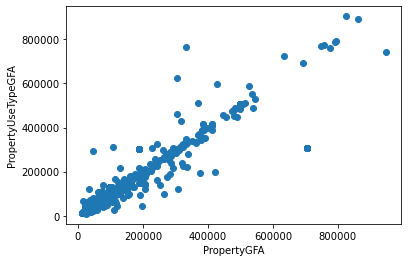

In [812]:
plt.plot(df_check_superficie['PropertyGFA'],df_check_superficie['PropertyUseTypeGFA'], "o")
plt.xlabel("PropertyGFA")
plt.ylabel("PropertyUseTypeGFA")
plt.show()

Le graphique montre bien une corrélation entre la somme des variables 'PropertyGFAParking' et 'PropertyGFABuilding(s)' etla somme des variables 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA' et 'ThirdLargestPropertyUseTypeGFA'

Je décide de retirer les variables 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA' et 'ThirdLargestPropertyUseTypeGFA' car la décomposition Buiding/Parking est plus pertinente pour la prédiction.

In [813]:
df_building_15_16_V20=df_building_15_16_V20.drop(columns=['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA'], axis=1).fillna(0).copy()

Je vérifie que toutes mes variables sont bien remplies

In [814]:
nb_lignes = df_building_15_16_V20.index.size

rows = []

for nom_colonne in df_building_15_16_V20.columns.values :
    nb_na = df_building_15_16_V20[nom_colonne].isna().sum()
    rate_na = 100 * (1 - nb_na/nb_lignes)
    rows.append([nom_colonne,nb_na,rate_na])
    
df_remplissage_colonnes = pd.DataFrame(rows, columns=["Nom","nb na","% remplissage"]).sort_values(by=["% remplissage"],ascending=False)
df_remplissage_colonnes 

,Nom,nb na,% remplissage
0,YearBuilt,0,100.0
31,Second_OTHER-SERVICES,0,100.0
23,Largest_SELF-STORAGEFACILITY,0,100.0
24,Largest_SENIORCARECOMMUNITY,0,100.0
25,Largest_SUPERMARKET/GROCERYSTORE,0,100.0
26,Largest_WORSHIPFACILITY,0,100.0
27,Second_FITNESSCENTER/HEALTHCLUB/GYM,0,100.0
28,Second_NON-REFRIGERATEDWAREHOUSE,0,100.0
29,Second_OFFICE,0,100.0
30,Second_OTHER,0,100.0


Analyse exploratoire:

Je regarde l'éventuelle corrélation de 'ENERGYSTARScore' avec 'GHGEmissions(MetricTonsCO2e)'

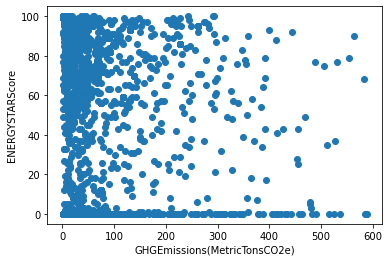

In [815]:
plt.plot(df_building_15_16_V20["GHGEmissions(MetricTonsCO2e)"],df_building_15_16_V20["ENERGYSTARScore"], "o")
plt.xlabel("GHGEmissions(MetricTonsCO2e)")
plt.ylabel("ENERGYSTARScore")
plt.show()

Je n'identifie pas de corrélation entre 'ENERGYSTARScore' et 'GHGEmissions(MetricTonsCO2e)'.

Je vais sélectionner quelles variable cible je conserve.

J'étudie la répartition des variables éligibles comme variables cibles.

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Density'>

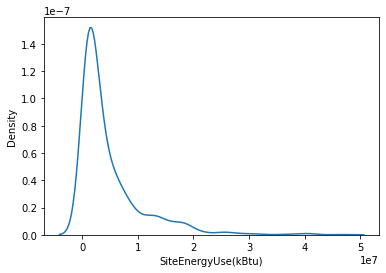

In [816]:
sns.kdeplot(data=df_building_15_16_V20['SiteEnergyUse(kBtu)'])

<AxesSubplot:xlabel='SiteEnergyUseWN(kBtu)', ylabel='Density'>

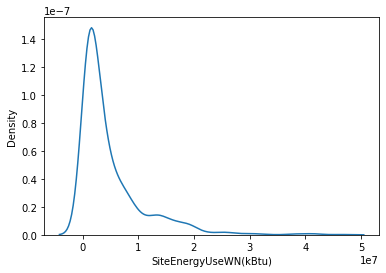

In [817]:
sns.kdeplot(data=df_building_15_16_V20['SiteEnergyUseWN(kBtu)'])

In [818]:
df_building_15_16_V20[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']].skew()

SiteEnergyUse(kBtu)      2.611231
SiteEnergyUseWN(kBtu)    2.567501
dtype: float64

In [819]:
df_building_15_16_V20[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']].kurtosis()

SiteEnergyUse(kBtu)      9.261945
SiteEnergyUseWN(kBtu)    8.997790
dtype: float64

Les indices de Skewness et Kurtosis pour les 2 variables sont similaires. Par contre 'SiteEnergyUseWN(kBtu)' est une valeur recalculée par rapport à la météo moyenne des 30 dernières années. Je préfrère conserver 'SiteEnergyUse(kBtu)' car elle est plus proche de la mesure et n'inclut pas un calcul qui doi lui-même intègrer des hypothèses et donc rajouter de possibles biais.

In [820]:
df_building_15_16_V20=df_building_15_16_V20.drop(['SiteEnergyUseWN(kBtu)'],axis=1).copy()

Je graphe les variables 2 à 2 pour identifier d'éventuelles corrélations.

In [821]:
df_bivarie=df_building_15_16_V20[[
                'YearBuilt',
                'NumberofFloors',
                'PropertyGFAParking',
                'PropertyGFABuilding(s)',
                'SiteEnergyUse(kBtu)',
                'Electricity(kBtu)',
                'NaturalGas(kBtu)',
                'GHGEmissions(MetricTonsCO2e)',
                'ENERGYSTARScore']]

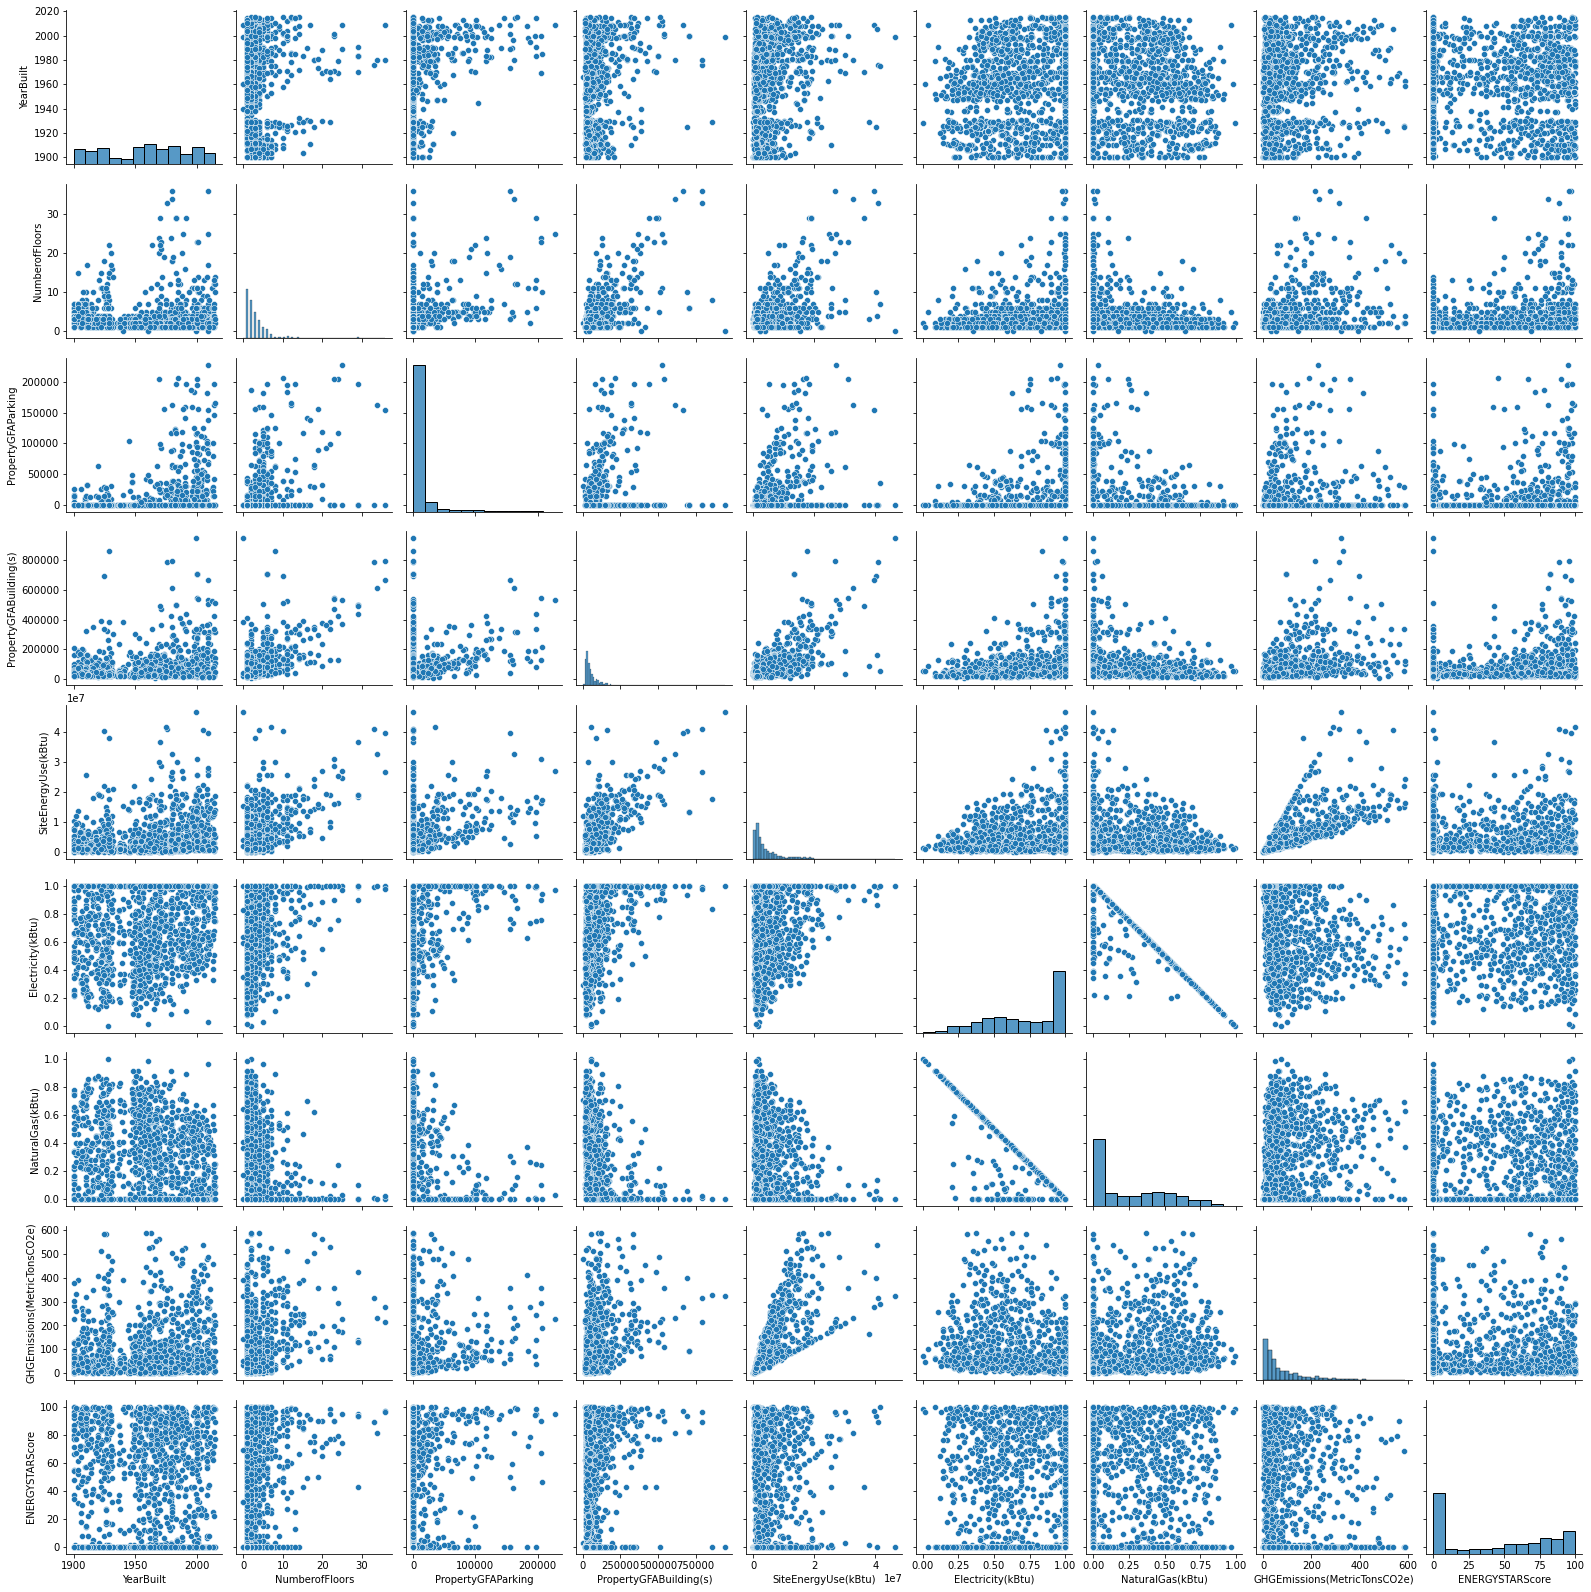

In [822]:
sns.pairplot(df_bivarie, height=2.5)

Je ne prends pas les variables "one-hot" créées car cela serait illisible sur le cercle des corrélations. 

In [823]:
data_pca = df_building_15_16_V20[[
                'YearBuilt',
                'NumberofFloors',
                'PropertyGFAParking',
                'PropertyGFABuilding(s)',
                'SiteEnergyUse(kBtu)',
                'Electricity(kBtu)',
                'NaturalGas(kBtu)',
                'GHGEmissions(MetricTonsCO2e)']]

ENERGYSTARScore = df_building_15_16_V20["ENERGYSTARScore"]

In [824]:
data_pca.shape[0]

1457

Je réalise une 1ère ACP en indiquant l'ENERGYSTARScore de chaque individus avec un dégradé de couleur 

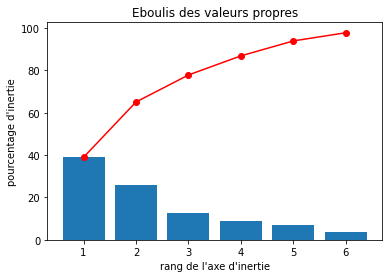

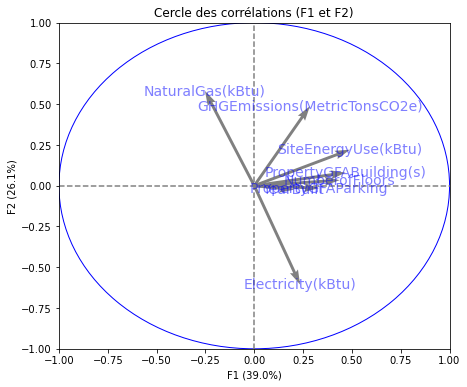

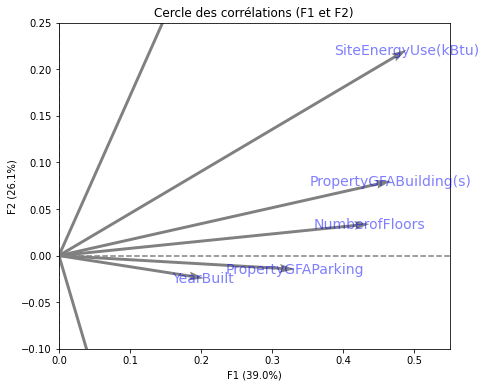

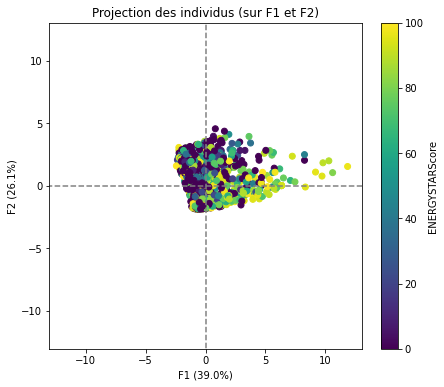

In [825]:
n_comp = 6

# préparation des données pour l'ACP
#data_pca = data_pca[~data_pca['ENERGYSTARScore'].isnull()].fillna(0)

X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(0,1)],lims=[0,.55,-0.1,0.25], labels = np.array(features))
display_factorial_planes(X_projected, n_comp, pca, [(0,1)] ,illustrative_var = ENERGYSTARScore, legend = "ENERGYSTARScore")

plt.show()

La projection des individus conforte cette hypothèse l'ENERGYSTARScore s'améliore avec l'usage de l'électricité et se dégrade au contraire avec l'usage du gaz.

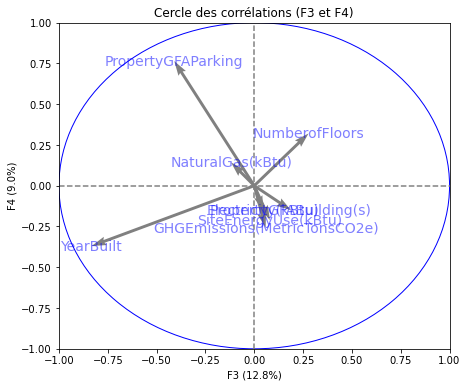

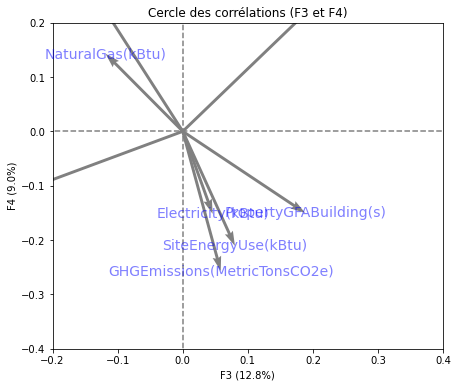

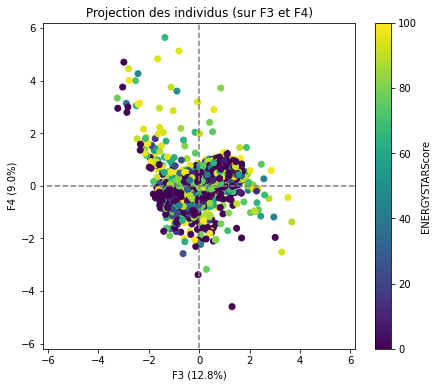

In [826]:
display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(2,3)],lims=[-.2,.4,-0.4,0.2], labels = np.array(features))
display_factorial_planes(X_projected, n_comp, pca, [(2,3)], illustrative_var = ENERGYSTARScore, legend = "ENERGYSTARScore")

plt.show()

L'usage de la vapeur permet clairement de dissocier un groupe de bâtiments des autres. L'usage de la vapeur semble être corrélée avec un bon ENERGYSTARScore.

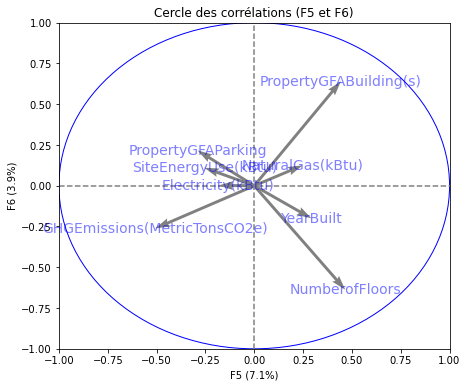

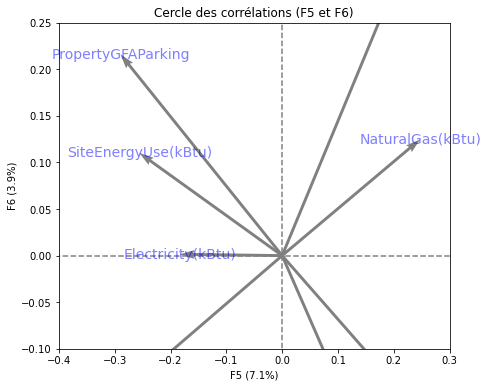

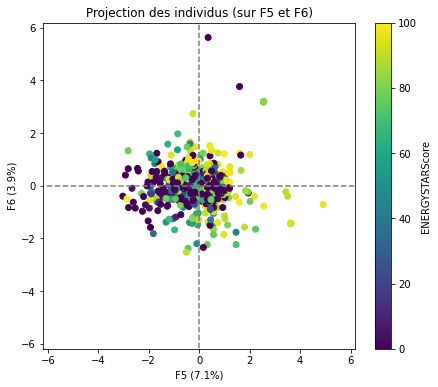

In [827]:
display_circles(pcs, n_comp, pca, [(4,5)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(4,5)],lims=[-0.4,0.3,-0.1,0.25], labels = np.array(features))
display_factorial_planes(X_projected,n_comp, pca, [(4,5)], illustrative_var = ENERGYSTARScore, legend = "ENERGYSTARScore")

plt.show()

Les 5ème et 6ème axes principaux d'inertie sont en-dessous du critère de

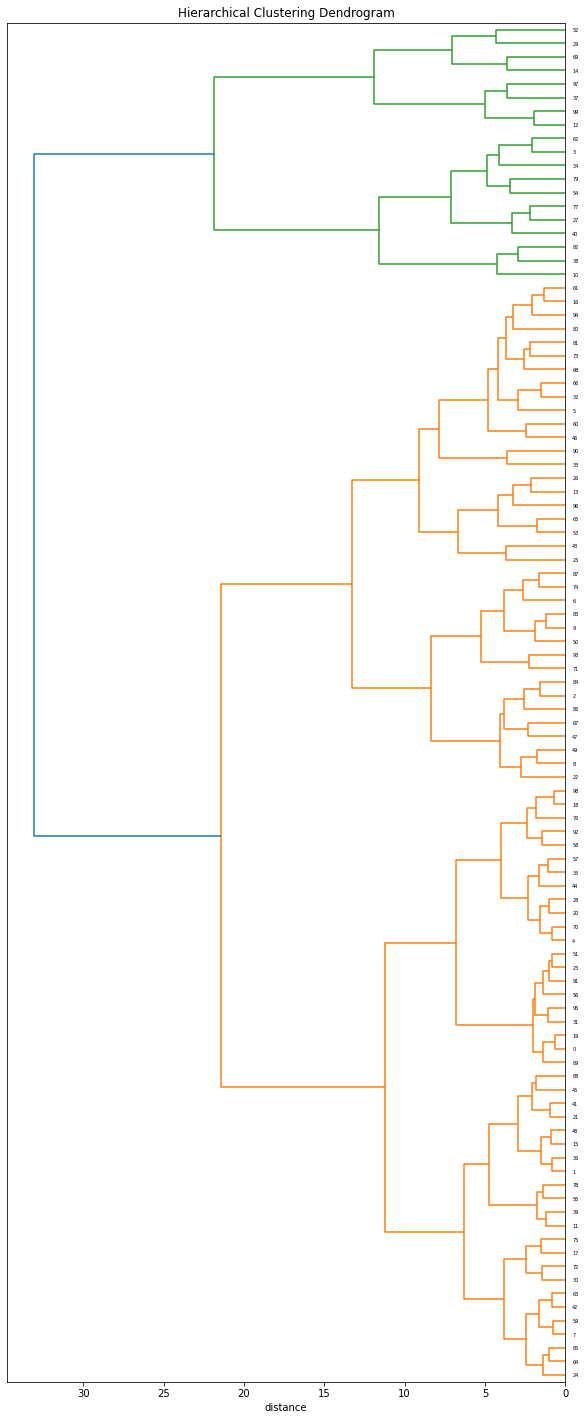

In [828]:
# Clustering par K-means
km = KMeans(n_clusters= 100)
km.fit(X_scaled)

clusters_kmeans = range(100)
centroids_after_kmeans = km.cluster_centers_

# Clustering hiérarchique
Z = linkage(centroids_after_kmeans, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names=clusters_kmeans)

Avec 4 clusters nous obtenons un bon ratio synthèse/détail

In [829]:
# Nombre de clusters souhaités
n_clust = 4

# Clustering par K-means
km = KMeans(n_clusters= n_clust)
km.fit(X_scaled)

KMeans(n_clusters=4)

In [830]:
# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
n_comp=6
pca = decomposition.PCA(n_components=n_comp).fit(X_scaled)
X_projected = pca.transform(X_scaled)

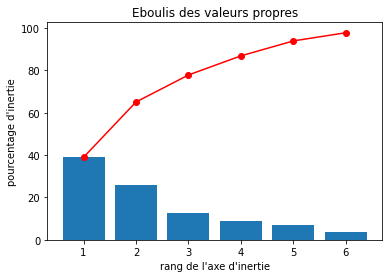

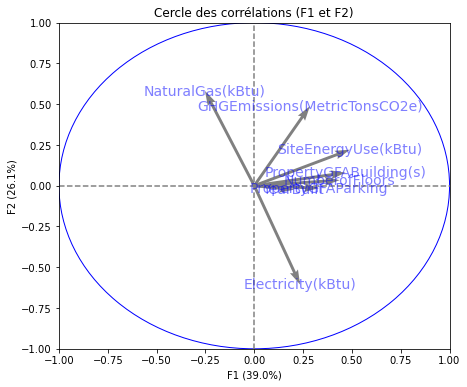

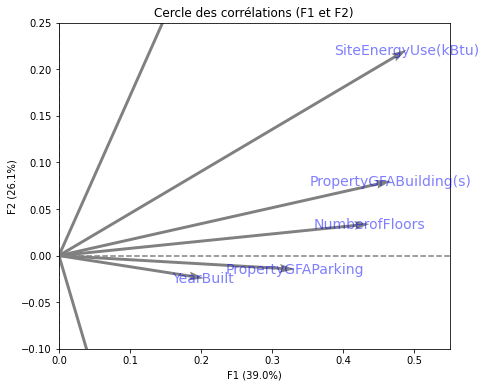

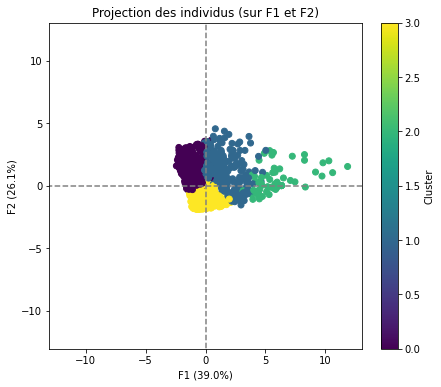

In [831]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_

display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(0,1)],lims=[0,.55,-0.1,0.25], labels = np.array(features))

display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = clusters, legend = "Cluster")

plt.show()

Je constate que les bâtiments peuvent être bien séparés en fonction de l'usage du gaz, de leur nombre d'étages et de leur année de construction 

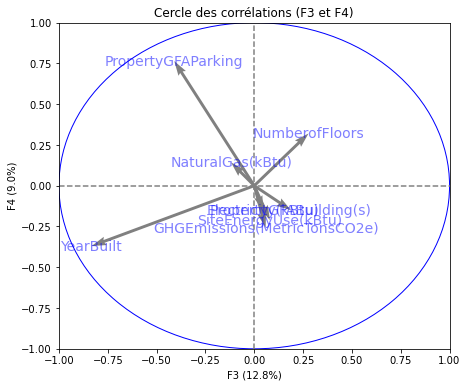

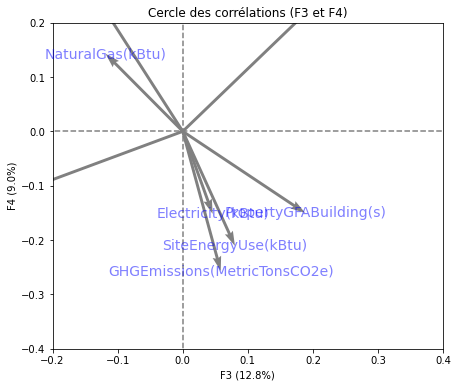

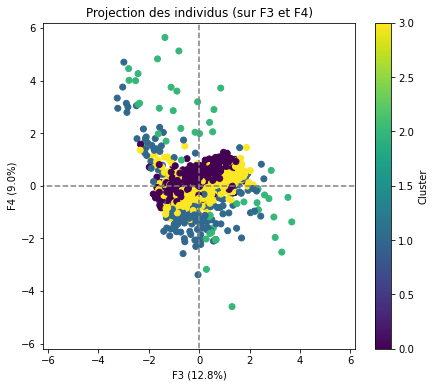

In [832]:
display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(2,3)],lims=[-.2,.4,-0.4,0.2], labels = np.array(features))
display_factorial_planes(X_projected, n_comp, pca, [(2,3)], illustrative_var = clusters, legend = "Cluster")

plt.show()

Je constate que les bâtiments peuvent être bien séparés en fonction de l'usage de la vapeur.

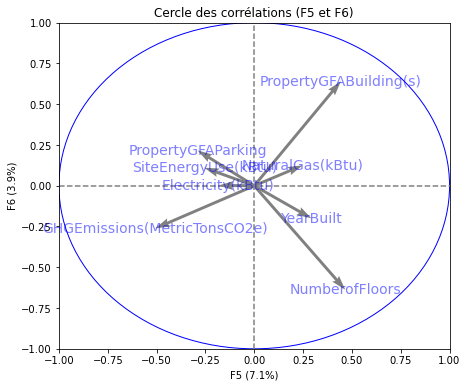

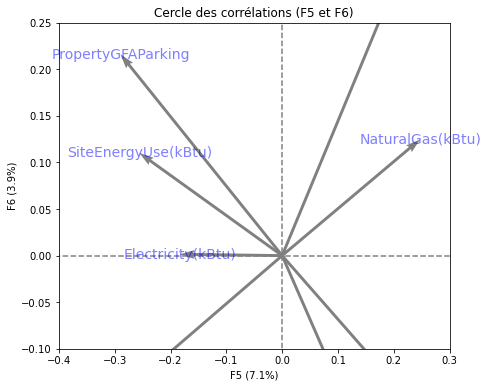

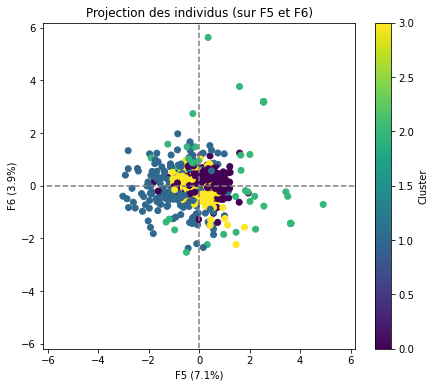

In [833]:
display_circles(pcs, n_comp, pca, [(4,5)], labels = np.array(features))
display_circles(pcs, n_comp, pca, [(4,5)],lims=[-0.4,0.3,-0.1,0.25], labels = np.array(features))
display_factorial_planes(X_projected, n_comp, pca, [(4,5)], illustrative_var = clusters, legend = "Cluster")
plt.show()

In [834]:
df_building_15_16_V20.to_csv('df_building_ML.csv')